In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("D:\\DRUG\\Drug_CNN\\data_for_gnn.tsv",sep='\t')

In [3]:
df.head()

,smiles,interact_with_adenosine
0,BrC1=C(NC2=NCCN2)C=CC2=NC=CN=C12,0
1,C#CC1=CC=CC(NC2=NC=NC3=C2C=C2OCCOCCOCCOC2=C3)=C1,0
2,C#CCN[C@@H]1CCC2=C1C=CC=C2,0
3,CC(C)(C)C1=CC=C(C=C1)C(=O)CCCN1CCC(CC1)OC(C1=C...,1
4,C(C1=NCCN1)C1=CC=CC2=CC=CC=C12,0


In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np


def fingerprint_to_array(fingerprint):
    return np.fromstring(fingerprint.ToBitString(), dtype=np.uint8) - ord('0')


def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    fingerprint_array = fingerprint_to_array(fingerprint)
    return fingerprint_array

In [11]:
input_data=[]
for x,y in zip(df['smiles'],df['interact_with_adenosine']):
    tsr=smiles_to_fingerprint(x)
    input_data.append([tsr,y])


C:\Users\Abhishek Sinha\AppData\Local\Temp\ipykernel_9404\1408840982.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(fingerprint.ToBitString(), dtype=np.uint8) - ord('0')


In [12]:
import numpy as np

In [13]:
def split_dataset(dataset, ratio):
    """Shuffle and split a dataset."""
    np.random.seed(1234)  # fix the seed for shuffle.
    np.random.shuffle(dataset)
    n = int(ratio * len(dataset))
    return dataset[:n], dataset[n:]

In [14]:
dataset_train, dataset_test=split_dataset(input_data,0.8)

In [16]:
train_gen=np.array([np.array(x[0])for x in dataset_train])
train_lab=np.array([x[1] for x in dataset_train])
test_gen=np.array([np.array(x[0]) for x in dataset_test])
test_lab=np.array([x[1] for x in dataset_test])

In [18]:
from tensorflow.keras.utils import to_categorical
train_lab=to_categorical(train_lab,2)
test_lab=to_categorical(test_lab,2)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es= EarlyStopping(monitor="accuracy",min_delta=0.04,patience=6,verbose=1,mode='auto')
mc=ModelCheckpoint(monitor="accuracy",filepath="D:\Phase II Project Work\DRUG\Drug_CNN\DTI\DTI.h5",verbose=1,save_best_only=True,mode='auto')
cd=[es,mc]

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D,MaxPool1D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D,GaussianNoise,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [24]:
train_gen.shape[1]

1024

In [26]:
import tensorflow as tf
# base_model = tf.keras.applications.EfficientNetB2(weights='imagenet',input_shape=(256,256,1), include_top=False)
# base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)
# with tf.device('/GPU:0'):
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu',padding='Same', input_shape=(train_gen.shape[1],1)))
model.add(MaxPool1D(pool_size=1))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPool1D(pool_size=1))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1024, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1024, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1022, 64)          12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1022, 64)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 1020, 64)          12352     
                                                                 
 flatten (Flatten)           (None, 65280)             0

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall'])

In [28]:

              
hs=model.fit(
    train_gen,
    train_lab,
    batch_size=16,
    epochs=8,
    verbose=1,  
    validation_data=(test_gen,test_lab),
    callbacks=cd
    )


Epoch 1/8
100/100 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8626 - precision: 0.8626 - recall: 0.8626
Epoch 1: accuracy improved from -inf to 0.86261, saving model to D:\Phase II Project Work\DRUG\Drug_CNN\DTI\DTI.h5
100/100 [==============================] - 7s 29ms/step - loss: 0.3294 - accuracy: 0.8626 - precision: 0.8626 - recall: 0.8626 - val_loss: 0.2783 - val_accuracy: 0.8722 - val_precision: 0.8722 - val_recall: 0.8722
Epoch 2/8
100/100 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724
Epoch 2: accuracy improved from 0.86261 to 0.97240, saving model to D:\Phase II Project Work\DRUG\Drug_CNN\DTI\DTI.h5
100/100 [==============================] - 2s 23ms/step - loss: 0.0941 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - val_loss: 0.1349 - val_accuracy: 0.9699 - val_precision: 0.9699 - val_recall: 0.9699
Epoch 3/8
100/100 [==============================] - ETA: 0s - loss: 0.0394

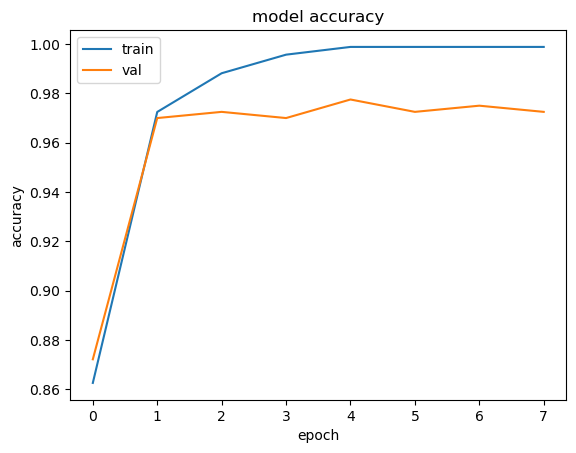

In [29]:
from matplotlib import pyplot as plt
plt.plot(hs.history['accuracy'])
plt.plot(hs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
import numpy as np
def predict_output(x,model):
    tsr=smiles_to_fingerprint(x)
    res=int(np.argmax(model.predict(np.array([tsr,]))))
    print(res)
    if(res==1):
        print("the drugs will interact with adenosine ")
    else:
        print("the drugs will not interact with adenosine" )

In [35]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

def draw_3d(mols):
    
    mol = Chem.MolFromSmiles(mols)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())


    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(mblock, 'sdf')
    viewer.setStyle({'stick':{}})
    viewer.setBackgroundColor('0xeeeeee')
    viewer.zoomTo()
    viewer.show()

def draw_2d(mols):
     return Draw.MolToImage(Chem.MolFromSmiles(mols),size=(400,400))


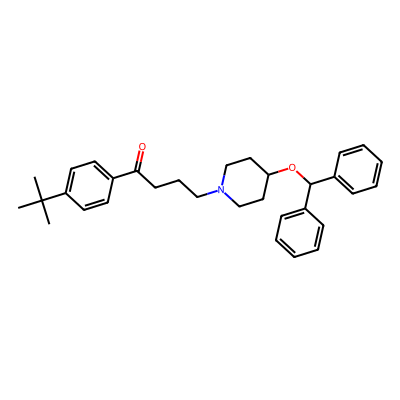

In [39]:
x="CC(C)(C)C1=CC=C(C=C1)C(=O)CCCN1CCC(CC1)OC(C1=CC=CC=C1)C1=CC=CC=C1"
draw_2d(x)

In [36]:
draw_3d(x)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [41]:
from tensorflow import keras
model = keras.models.load_model('D:\\Phase II Project Work\\DRUG\\Drug_CNN\\DTI\\DTI.h5')

In [42]:
predict_output(x,model)

1/1 [==============================] - 0s 95ms/step
1
the drugs will interact with adenosine with probability 


In [33]:
y="OCCN(CCO)C1=NC2=C(N=C(N=C2N2CCCCC2)N(CCO)CCO)C(=N1)N1CCCCC1"
predict_output(y,model)

1/1 [==============================] - 0s 25ms/step
0
the drugs will not interact with adenosine


C:\Users\Abhishek Sinha\AppData\Local\Temp\ipykernel_9404\1408840982.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(fingerprint.ToBitString(), dtype=np.uint8) - ord('0')
